In [ ]:
# This notebook demonstrates how to fine-tune the BiomedCLIP model on a custom dataset using PyTorch and the Hugging Face Transformers library.
# dataset: the Indiana CXR dataset hosted by NLM, NIH, https://openi.nlm.nih.gov/


import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments, Trainer
from open_clip import create_model_from_pretrained, get_tokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch import nn
import json
import random
import pandas as pd

# This line sets the environment variable for the Hugging Face cache directory on Biowulf cluster node. Replace "username" with your actual username.
os.environ["HF_HOME"] = "/data/username/.cache/huggingface"

In [ ]:
# fectch the model and tokenizer from Hugging Face Hub


MODEL_NAME = "hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"
clip_model, processor = create_model_from_pretrained(
    MODEL_NAME,
    return_transform=True
)
tokenizer = get_tokenizer(
    MODEL_NAME,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768

In [3]:
# The BiomedCLIP-PubMedBERT_256-vit_base_patch16_224
# - A ViT model - model.visual.trunk.blocks (12 layers)
# - A PubMedBERT model - model.text.transformer.encoder.layer (12 layers)

def freeze_biomedclip_except_last_two_layers(model):
    for param in model.parameters():
        param.requires_grad = False

    vit_blocks = model.visual.trunk.blocks
    for block in vit_blocks[-1:]:
        for param in block.parameters():
            param.requires_grad = True

    bert_layers = model.text.transformer.encoder.layer
    for layer in bert_layers[-1:]:
        for param in layer.parameters():
            param.requires_grad = True

    print("✅ Unfroze last 2 layers of ViT and PubMedBERT.")

In [4]:
freeze_biomedclip_except_last_two_layers(clip_model)

✅ Unfroze last 2 layers of ViT and PubMedBERT.


In [5]:
labels = [
    "enlarged cardiomediastinum", "cardiomegaly", "lung opacity", "lung lesion", "edema",
    "consolidation", "pneumonia", "atelectasis", "pneumothorax", "pleural effusion",
    "pleural other", "fracture", "support devices"
]
# 'Pulmonary Atelectasis' is a duplicate of 'Atelectasis'
# 'Pleural Effusion' is a duplicate of 'pleural effusion'
print(len(labels), "labels before deduplication")
labels = list(set(label.lower() for label in labels))  # deduplicate and lowercase
entity2id = {label: idx for idx, label in enumerate(sorted(labels))}

13 labels before deduplication


In [6]:
print(f"✅ Number of labels: {len(entity2id)}")
print(entity2id)

✅ Number of labels: 13
{'atelectasis': 0, 'cardiomegaly': 1, 'consolidation': 2, 'edema': 3, 'enlarged cardiomediastinum': 4, 'fracture': 5, 'lung lesion': 6, 'lung opacity': 7, 'pleural effusion': 8, 'pleural other': 9, 'pneumonia': 10, 'pneumothorax': 11, 'support devices': 12}


In [7]:
label_ids = tokenizer(labels, context_length=256)

In [8]:
from torch.utils.data import Dataset
import torch
from PIL import Image
import pandas as pd

class BiomedCLIPMultiTaskDataset(Dataset):
    def __init__(self, df, processor, tokenizer, device="cuda", max_length=256):
        """
        Args:
            df (pd.DataFrame): Must contain 'image', 'caption', 'label'
            processor: Image processor (BiomedCLIP image transform)
            tokenizer: BiomedCLIP tokenizer (for captions)
            device: torch device
            max_length: max token length for text
        """
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row["image"]
        caption = str(row["caption"]) if pd.notnull(row["caption"]) else ""
        label = int(row["label"])

        # === Load and preprocess image ===
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.processor(image)  # shape: [3, H, W]

        # === Tokenize text ===
        input_ids = self.tokenizer(caption, context_length=self.max_length).squeeze(0)  # shape: [L]

        return {
            "input_ids": input_ids,
            "pixel_values": image_tensor,
            "label": torch.tensor(label, dtype=torch.long),
            "image_path": image_path
        }

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Load CSV - replace with your actual path, we put all image path and the corresponding captions, and the binary label in a CSV file
df = pd.read_csv("/data/username/indiana/data/train/caption.csv")

# 2) Stratified train/validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42,
)

# 3) Create your datasets
train_ds = BiomedCLIPMultiTaskDataset(train_df, processor, tokenizer, entity2id)
val_ds = BiomedCLIPMultiTaskDataset(val_df, processor, tokenizer, entity2id)

In [ ]:
# collate function to handle batching

def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch]) # [B, L]
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])
    image_paths = [item["image_path"] for item in batch]

    return {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
        "label": labels,
        "image_path": image_paths,
    }

In [11]:
batch_size = 128
num_workers = 4  # adjust to your CPU/GPU

train_dataloader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_dataloader = DataLoader(
    val_ds,
    batch_size=batch_size,      # ← pull in the whole set at once
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CLIPMultiTaskClassifier is a multi-task classifier that uses CLIP embeddings for binary classification.
# It takes pixel values and input text tokens (IDs) (captions) as inputs and outputs binary logits.

class CLIPMultiTaskClassifier(nn.Module):
    def __init__(self, clip_model, label_ids=None, embed_dim=512):
        super().__init__()
        self.clip = clip_model
        self.embed_dim = embed_dim
        self.label_ids = label_ids  # still kept if you later want to re-enable multi-label
        self.binary_cls_head = nn.Linear(embed_dim, 1)  # Binary classification
        self.dropout = nn.Dropout(0.3)

    def forward(self, pixel_values, input_ids, attention_mask=None):
        """
        Args:
            pixel_values: Tensor of shape [B, 3, H, W]
            input_ids: Tensor of shape [B, L] (captions)
            attention_mask: optional, unused here
        Returns:
            Dict with binary_logits and embeddings
        """
        # === Get CLIP embeddings ===
        image_embeds = self.clip.encode_image(pixel_values)    # [B, D]
        text_embeds = self.clip.encode_text(input_ids)         # [B, D]

        # === Fuse features for binary classification ===
        fused = (image_embeds + text_embeds) / 2               # [B, D]
        fused = self.dropout(fused)
        binary_logits = self.binary_cls_head(fused).squeeze(-1)  # [B]

        return {
            "binary_logits": binary_logits,
            "image_embeds": image_embeds,
            "text_embeds": text_embeds,
        }

In [ ]:
# CLIPLoss is a contrastive loss function for CLIP embeddings.
# It computes the cross-entropy loss between image and text embeddings.
# It normalizes the embeddings and computes logits for both image-to-text and text-to-image directions

class CLIPLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, image_embeds, text_embeds):
        image_embeds = F.normalize(image_embeds, dim=1)
        text_embeds = F.normalize(text_embeds, dim=1)

        logits_i2t = image_embeds @ text_embeds.T / self.temperature
        logits_t2i = text_embeds @ image_embeds.T / self.temperature

        targets = torch.arange(image_embeds.size(0), device=image_embeds.device)
        loss_i2t = F.cross_entropy(logits_i2t, targets)
        loss_t2i = F.cross_entropy(logits_t2i, targets)

        return (loss_i2t + loss_t2i) / 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# SupConLoss is a supervised contrastive loss function.
# It computes the loss based on normalized feature vectors and class labels.
# It constructs a positive pair mask using the labels and computes the loss accordingly.


class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """
        Args:
            features: [B, D] normalized feature vectors
            labels: [B] class indices
        Returns:
            Scalar contrastive loss
        """
        device = features.device
        B = features.size(0)

        # Normalize features
        features = F.normalize(features, dim=1)

        # Cosine similarity matrix [B, B]
        sim_matrix = torch.matmul(features, features.T) / self.temperature

        # Remove self-comparisons
        mask = torch.eye(B, dtype=torch.bool).to(device)
        sim_matrix.masked_fill_(mask, -1e9)

        # === Construct positive pair mask using torch.eq ===
        labels = labels.view(-1, 1)  # [B, 1]
        positive_mask = torch.eq(labels, labels.T).to(device) & (~mask)

        # Log-softmax over rows
        log_probs = F.log_softmax(sim_matrix, dim=1)

        # Count positives per sample
        pos_counts = positive_mask.sum(dim=1)
        valid = pos_counts > 0

        if valid.sum() == 0:
            return torch.tensor(0.0, device=device, requires_grad=True)

        # Mean loss over valid samples
        loss = -(log_probs * positive_mask).sum(dim=1)[valid] / pos_counts[valid]
        return loss.mean()

In [ ]:
# TotalLoss is a composite loss function that combines binary classification loss, supervised contrastive loss, and CLIP loss.
# It is a multi-task loss that computes the individual losses and combines them with specified weights.

class TotalLoss(nn.Module):
    def __init__(self,
                 binary_weight=1.0,
                 supcon_weight=1.0,
                 clip_weight=1.0,
                 temperature=0.07):
        super().__init__()
        self.binary_loss_fn = nn.BCEWithLogitsLoss()
        self.supcon_loss_fn = SupConLoss(temperature)
        self.clip_loss_fn = CLIPLoss(temperature)

        self.binary_weight = binary_weight
        self.supcon_weight = supcon_weight
        self.clip_weight = clip_weight

    def forward(self, outputs, labels):
        binary_logits = outputs["binary_logits"]     # [B]
        image_embeds = outputs["image_embeds"]       # [B, D]
        text_embeds = outputs["text_embeds"]         # [B, D]

        # Normalize and fuse features for SupCon
        image_feats = F.normalize(image_embeds, dim=1)
        text_feats = F.normalize(text_embeds, dim=1)
        fused_feats = (image_feats + text_feats) / 2

        # Compute each loss
        binary_loss = self.binary_loss_fn(binary_logits, labels.float())
        supcon_loss = self.supcon_loss_fn(fused_feats, labels=labels)
        clip_loss = self.clip_loss_fn(image_embeds, text_embeds)

        # Combine
        total = (
            self.binary_weight * binary_loss +
            self.supcon_weight * supcon_loss +
            self.clip_weight * clip_loss
        )

        return {
            "total": total,
            "binary": binary_loss,
            "supcon": supcon_loss,
            "clip": clip_loss
        }

In [ ]:
# ==== Create the classifier with the clip model ====
classifier = CLIPMultiTaskClassifier(clip_model).to(device)


# These weights were determined to balance the contributions of each loss term during training.
# The values are set based on the Bayesian optimization results, which found the following optimal weights:
# - binary_weight: 0.69
# - supcon_weight: 1.97
# - clip_weight: 0.46
# - temperature: 0.07
# These weights were determined to balance the contributions of each loss term during training.

# ==== Loss function for training ====
loss_fn = TotalLoss(
    binary_weight=0.69,
    supcon_weight=1.97,
    clip_weight=0.46,
    temperature=0.07,
)

# === Optimizer with differential learning rates ===
optimizer = torch.optim.AdamW([
    {"params": classifier.clip.parameters(), "lr": 1e-5},
    {"params": classifier.binary_cls_head.parameters(), "lr": 1e-4},
], weight_decay=1e-4)

# === Scheduler: Warmup + Cosine ===
num_epochs = 20
total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(0.1 * total_steps)
cosine_steps = total_steps - warmup_steps

warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=warmup_steps)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cosine_steps)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [warmup_scheduler, cosine_scheduler], milestones=[warmup_steps])


In [17]:
import json
import os
from tqdm import tqdm
import torch

# === Setup paths and tracking ===
best_val_acc = 0.0
model_save_path = "/data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt"
history_save_path = "/data/liangz2/indiana/multi_task_model/training_history.json"

# Initialize history dictionary
history = {
    "epoch": [],
    "batch": [],
    "loss": [],
    "binary_loss": [],
    "supcon_loss": [],
    "acc": [],
    "val_loss": [],
    "val_binary_loss": [],
    "val_supcon_loss": [],
    "val_acc": [],
}

# === Training Loop ===
for epoch in range(num_epochs):
    classifier.train()
    train_pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"[Epoch {epoch+1}] Training")

    for batch_idx, batch in train_pbar:
        input_ids = batch["input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = classifier(pixel_values=pixel_values, input_ids=input_ids)
        loss_dict = loss_fn(outputs, labels)
        loss = loss_dict["total"]
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accuracy
        binary_preds = (torch.sigmoid(outputs["binary_logits"]) > 0.5).long()
        acc = (binary_preds == labels).float().mean().item()

        # Log
        history["epoch"].append(epoch + 1)
        history["batch"].append(batch_idx + 1)
        history["loss"].append(loss.item())
        history["binary_loss"].append(loss_dict["binary"].item())
        history["supcon_loss"].append(loss_dict["supcon"].item())
        history["acc"].append(acc)

        train_pbar.set_postfix({
            "loss": f"{loss.item():.2f}",
            "acc": f"{acc:.2f}",
        })

    # === Validation ===
    classifier.eval()
    val_pbar = tqdm(val_dataloader, desc=f"[Epoch {epoch+1}] Validation")
    val_loss = 0
    val_binary_loss = 0
    val_supcon_loss = 0
    val_acc = []

    with torch.no_grad():
        for batch in val_pbar:
            input_ids = batch["input_ids"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            outputs = classifier(pixel_values=pixel_values, input_ids=input_ids)
            loss_dict = loss_fn(outputs, labels)

            val_loss += loss_dict["total"].item()
            val_binary_loss += loss_dict["binary"].item()
            val_supcon_loss += loss_dict["supcon"].item()

            binary_preds = (torch.sigmoid(outputs["binary_logits"]) > 0.5).long()
            val_binary_acc = (binary_preds == labels).float().mean().item()
            val_acc.append(val_binary_acc)

            avg_val_acc = sum(val_acc) / len(val_acc)

            val_pbar.set_postfix({
                "val_loss": f"{loss_dict['total'].item():.2f}",
                "val_acc": f"{avg_val_acc:.2f}"
            })

    history["val_loss"].append(val_loss / len(val_dataloader))
    history["val_binary_loss"].append(val_binary_loss / len(val_dataloader))
    history["val_supcon_loss"].append(val_supcon_loss / len(val_dataloader))
    history["val_acc"].append(avg_val_acc)

    # === Save best model ===
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(classifier.state_dict(), model_save_path)
        print(f"✅ Best model saved (val_acc: {best_val_acc:.4f}) to {model_save_path}")

# === Save training history to JSON ===
with open(history_save_path, "w") as f:
    json.dump(history, f, indent=4)
print(f"📁 Training history saved to {history_save_path}")

[Epoch 1] Validation: 100%|██████████| 3/3 [00:15<00:00,  5.19s/it, val_loss=11.91, val_acc=0.68]


✅ Best model saved (val_acc: 0.6770) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 3] Validation: 100%|██████████| 3/3 [00:14<00:00,  4.97s/it, val_loss=11.70, val_acc=0.69]


✅ Best model saved (val_acc: 0.6929) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 4] Validation: 100%|██████████| 3/3 [00:15<00:00,  5.18s/it, val_loss=11.54, val_acc=0.70]


✅ Best model saved (val_acc: 0.7040) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 5] Validation: 100%|██████████| 3/3 [00:15<00:00,  5.10s/it, val_loss=11.41, val_acc=0.73]


✅ Best model saved (val_acc: 0.7304) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 6] Validation: 100%|██████████| 3/3 [00:14<00:00,  4.97s/it, val_loss=11.32, val_acc=0.74]


✅ Best model saved (val_acc: 0.7412) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 7] Validation: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it, val_loss=11.27, val_acc=0.76]


✅ Best model saved (val_acc: 0.7601) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 8] Validation: 100%|██████████| 3/3 [00:15<00:00,  5.03s/it, val_loss=11.23, val_acc=0.77]


✅ Best model saved (val_acc: 0.7749) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 9] Validation: 100%|██████████| 3/3 [00:15<00:00,  5.05s/it, val_loss=11.22, val_acc=0.79]


✅ Best model saved (val_acc: 0.7901) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 10] Validation: 100%|██████████| 3/3 [00:14<00:00,  4.98s/it, val_loss=11.21, val_acc=0.80]


✅ Best model saved (val_acc: 0.7983) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 11] Validation: 100%|██████████| 3/3 [00:14<00:00,  4.87s/it, val_loss=11.20, val_acc=0.82]


✅ Best model saved (val_acc: 0.8153) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 15] Validation: 100%|██████████| 3/3 [00:15<00:00,  5.22s/it, val_loss=11.16, val_acc=0.82]


✅ Best model saved (val_acc: 0.8235) to /data/liangz2/indiana/multi_task_model/best_clip_multitask_classifier.pt


[Epoch 20] Validation: 100%|██████████| 3/3 [00:14<00:00,  4.96s/it, val_loss=11.15, val_acc=0.82]

📁 Training history saved to /data/liangz2/indiana/multi_task_model/training_history.json


In [18]:
# Save model weights
model_path = "/data/liangz2/indiana/multi_classify/clip_multitask_classifier_final.pt"
torch.save(classifier.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")



✅ Model saved to /data/liangz2/indiana/multi_classify/clip_multitask_classifier_final.pt


In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = [
        "loss", "binary_loss", "supcon_loss", "acc",
        "val_loss", "val_binary_loss", "val_supcon_loss", "val_acc"
    ]
    titles = [
        "Train: Total Loss", "Train: Binary Loss", "Train: SupCon Loss", "Train: Accuracy",
        "Val: Total Loss", "Val: Binary Loss", "Val: SupCon Loss", "Val: Accuracy"
    ]

    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    axes = axes.flatten()

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        # If training metrics (logged per batch), smooth them using batch average per epoch
        if "val" not in metric:
            values = history[metric]
            epochs = history["epoch"]
            max_epoch = max(epochs)
            avg_per_epoch = []

            for e in range(1, max_epoch + 1):
                epoch_values = [v for v, ep in zip(values, epochs) if ep == e]
                avg_per_epoch.append(sum(epoch_values) / len(epoch_values) if epoch_values else 0.0)

            axes[i].plot(range(1, max_epoch + 1), avg_per_epoch, marker='o')
        else:
            axes[i].plot(range(1, len(history[metric]) + 1), history[metric], marker='o')

        axes[i].set_title(title)
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_training_history(history)

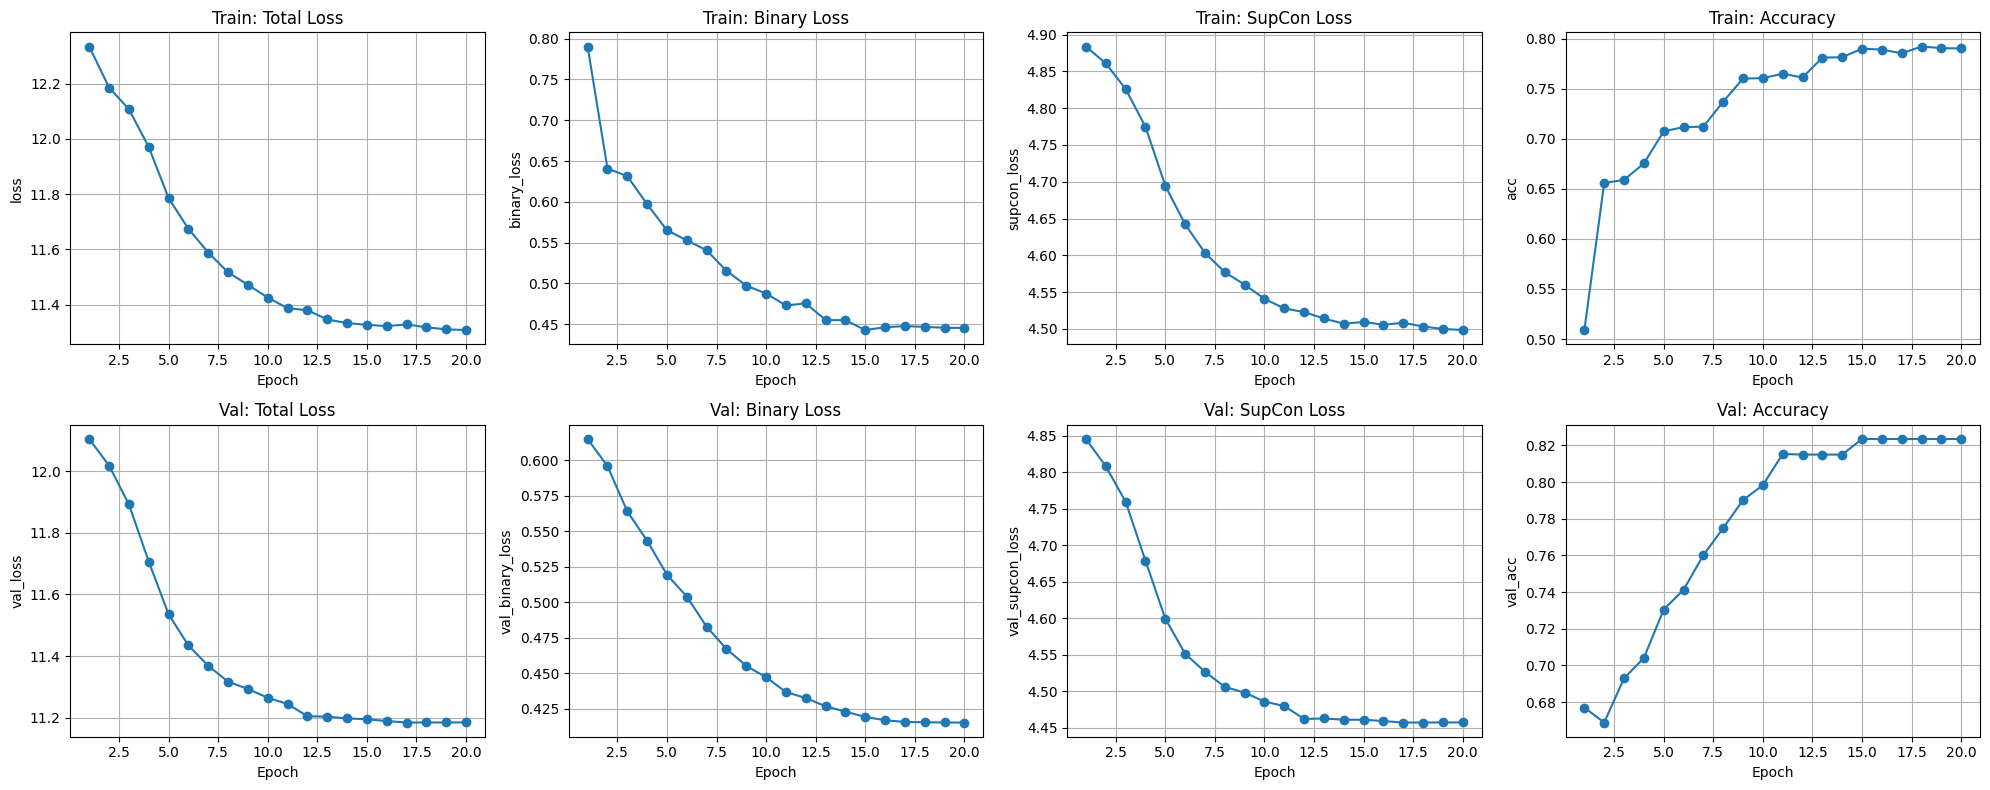

In [20]:
plot_training_history(history)

In [23]:
import matplotlib.pyplot as plt
import os

def plot_training_history(history, save_path="training_plot.png"):
    epochs = sorted(set(history["epoch"]))

    def average_by_epoch(values):
        """Compute average value per epoch from batch-logged metrics."""
        epoch_vals = []
        for e in epochs:
            vals = [v for v, ep in zip(values, history["epoch"]) if ep == e]
            avg = sum(vals) / len(vals) if vals else 0.0
            epoch_vals.append(avg)
        return epoch_vals

    # Compute per-epoch averages for training metrics
    loss_avg = average_by_epoch(history["loss"])
    supcon_loss_avg = average_by_epoch(history["supcon_loss"])
    acc_avg = average_by_epoch(history["acc"])

    val_loss = history["val_loss"]
    val_supcon_loss = history["val_supcon_loss"]
    val_acc = history["val_acc"]

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    axs[0].plot(epochs, loss_avg, label="Train Loss", marker='o')
    axs[0].plot(epochs, val_loss, label="Val Loss", marker='s')
    axs[0].set_title("Total Loss")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epochs, supcon_loss_avg, label="Train SupCon Loss", marker='o')
    axs[1].plot(epochs, val_supcon_loss, label="Val SupCon Loss", marker='s')
    axs[1].set_title("Supervised Contrastive Loss")
    axs[1].set_ylabel("SupCon Loss")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(epochs, acc_avg, label="Train Accuracy", marker='o')
    axs[2].plot(epochs, val_acc, label="Val Accuracy", marker='s')
    axs[2].set_title("Accuracy")
    axs[2].set_ylabel("Accuracy")
    axs[2].set_xlabel("Epoch")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()

    # Save plot
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    print(f"📊 Plot saved to {save_path}")

    plt.show()

📊 Plot saved to /data/liangz2/indiana/multi_classify/training_plot.png


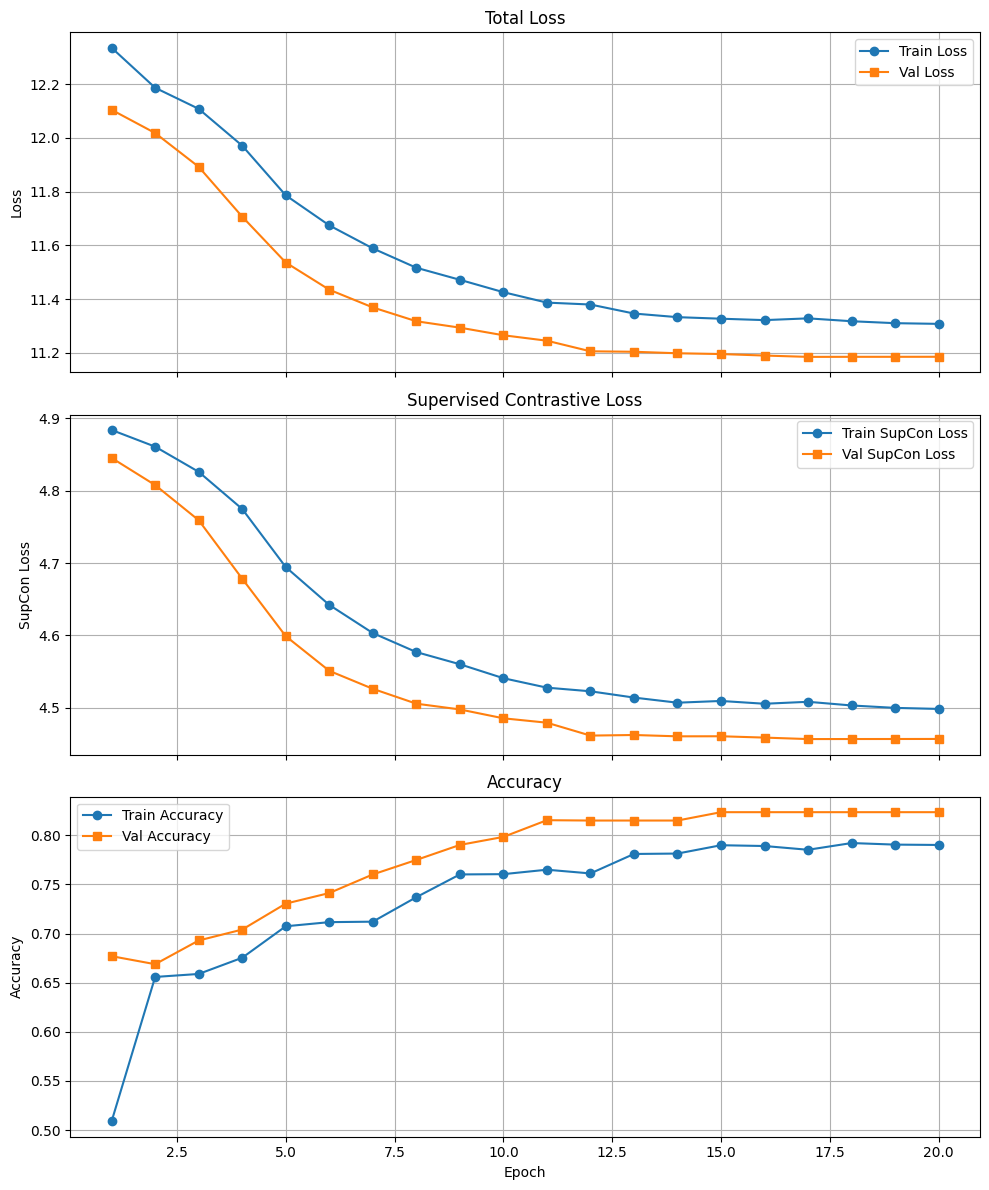

In [24]:
plot_path = "/data/liangz2/indiana/multi_classify/training_plot.png"
plot_training_history(history, save_path=plot_path)

In [ ]:
# Load the model for inference
classifier.load_state_dict(torch.load("clip_multitask_classifier.pt"))
classifier.to(device)
classifier.eval()